In [1]:
import json
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split


In [2]:
from gensim.models import KeyedVectors

chord_vectors = KeyedVectors.load("../../out/chord_vectors.bin")
INPUT_SIZE = OUTPUT_SIZE = chord_vectors["C"].size

In [3]:
class UltimateGuitarSongDataset(Dataset):
    def __init__(self, chord_vectors, filename="../../out/chord_progressions.json"):
        with open(filename) as f:
            songs = json.load(f)
            assert isinstance(songs, list)

        songs = [song[:8] for song in songs if len(song) > 8]

        songs = [
            [torch.from_numpy(chord_vectors[chord].copy()) for chord in song]
            for song in songs
        ]

        self.data = []
        for song in songs:
            self.data.append((torch.stack(song[:-1]), torch.stack(song[1:])))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

_, train_dataset, test_dataset = random_split(
    UltimateGuitarSongDataset(chord_vectors), [0.00, 0.80, 0.20]
)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True)

In [4]:
class RNNetwork(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, state_size):
        super().__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.state_size = state_size

        self.i2s = torch.nn.Linear(self.input_size + self.state_size, self.state_size)
        self.i2h = torch.nn.Linear(self.input_size + self.state_size, self.hidden_size)
        self.h2h = torch.nn.Linear(self.hidden_size, self.hidden_size)
        self.h2o = torch.nn.Linear(self.hidden_size, self.output_size)
        self.dropout = torch.nn.Dropout(0.1)

    def forward(self, i: torch.Tensor, state: torch.Tensor):
        i_ = torch.cat((i, state))
        s = self.i2s(i_)
        h = self.i2h(i_)
        h2 = self.h2h(torch.relu(h))
        o = self.h2o(torch.relu(h2))
        o = self.dropout(o)
        return o, s

    def init_hidden(self):
        return torch.zeros(self.state_size)

In [5]:
def train_loop(dataloader, model, loss, optimizer, epoch):
    model.train()
    total_loss = 0

    for batch_idx, (batched_x, batched_y) in enumerate(dataloader):
        cost = 0
        for x, y in zip(batched_x, batched_y):
            state = model.init_hidden()
            for i, (x_, y_) in enumerate(zip(x, y)):
                pred, state = model(x_, state)
                cost += loss(pred, y_)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()
        batch_loss = cost.item() / (batched_x.size(0) * batched_x.size(1) * batched_x.size(2))
        total_loss += batch_loss

        if batch_idx % 50 == 0:
            print(f"Batch {batch_idx} loss: {batch_loss}")

    return total_loss


def test_loop(dataloader, model, loss, wv, epoch):
    model.eval()
    test_loss, correct = 0, 0
    total_len = 0
    with torch.no_grad():
        for batch_idx, (batched_x, batched_y) in enumerate(dataloader):
            batch_loss = 0
            for x, y in zip(batched_x, batched_y):
                state = model.init_hidden()
                for x_, y_ in zip(x, y):
                    pred, state = model(x_, state)
                    batch_loss += loss(pred, y_)
                    similar = wv.similar_by_vector(pred.numpy(), topn=5)
                    if any(np.array_equal(wv[chord], y_) for chord, _ in similar):
                        correct += 1
            batch_loss /= batched_x.size(0) * batched_x.size(1) * batched_x.size(2)
            test_loss += batch_loss
            total_len += batched_x.size(0) * batched_x.size(1)

            if batch_idx % 50 == 0:
                print(f"Test Batch {batch_idx} loss: {batch_loss}")
    correct = correct / total_len * 100
    print(f"Accuracy: {correct:>0.1f}, Average Loss: {test_loss:>8f}")
    return test_loss.item(), correct



Using cpu device
Epoch: 1
---------------
Batch 0 loss: 1.021498543875558
Batch 50 loss: 0.7927825791495187
Batch 100 loss: 0.7068931715829032
Batch 150 loss: 0.741372994014195
Batch 200 loss: 0.5547615459987095
Batch 250 loss: 0.7080841064453125
Batch 300 loss: 0.6203805378505162
Batch 350 loss: 0.5868100438799176
Batch 400 loss: 0.6091019085475377
Batch 450 loss: 0.4876899378640311
Batch 500 loss: 0.6615431649344308
Batch 550 loss: 0.5827830178397042
Batch 600 loss: 0.6346584728785923
Batch 650 loss: 0.5743201119559151
Batch 700 loss: 0.5418025425502232
Batch 750 loss: 0.6387007577078683
Batch 800 loss: 0.6225663593837193
Batch 850 loss: 0.6509284973144531
Batch 900 loss: 0.6175460134233747
Batch 950 loss: 0.5702898842947823
Batch 1000 loss: 0.5241490772792271
Batch 1050 loss: 0.5951974051339286
Batch 1100 loss: 0.5757995332990374
Batch 1150 loss: 0.5122220175606864
Batch 1200 loss: 0.559298072542463
Batch 1250 loss: 0.49518067496163504
Batch 1300 loss: 0.5196561132158551
Loss in tra

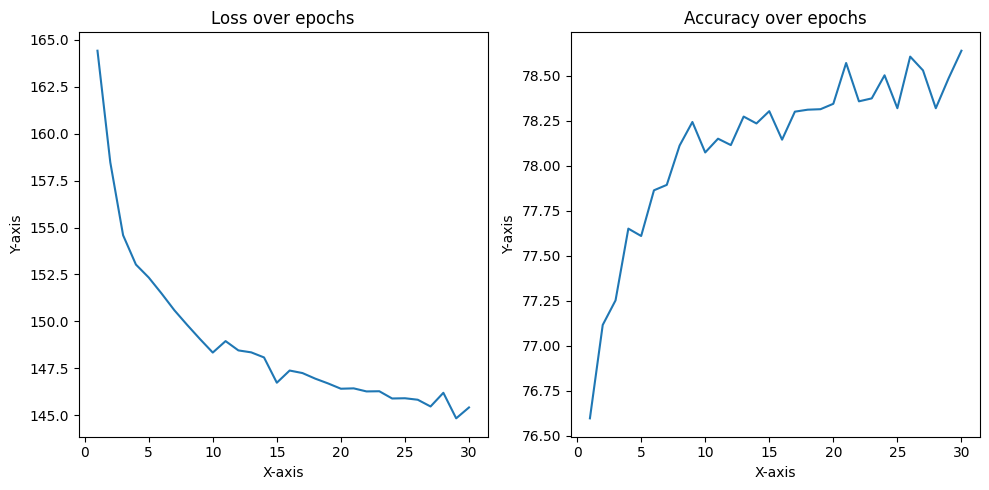

In [6]:
HIDDEN_SIZE = 30
STATE_SIZE = 20

def plot(epochs, losses, accuracies):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(epochs, losses)
    ax1.set_title('Loss over epochs')
    ax1.set_xlabel('X-axis')
    ax1.set_ylabel('Y-axis')

    ax2.plot(epochs, accuracies)
    ax2.set_title('Accuracy over epochs')
    ax2.set_xlabel('X-axis')
    ax2.set_ylabel('Y-axis')
    plt.tight_layout()
    plt.show()

def main():
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using {device} device")

    model = RNNetwork(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, STATE_SIZE).to(device)
    loss = nn.MSELoss()
    learning_rate = 0.0005
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    losses, accuracies = [], []
    epochs = 30
    for epoch in range(epochs):
        print(f"Epoch: {epoch+1}")
        print("---------------")
        cost = train_loop(train_dataloader, model, loss, optimizer, epoch)
        print("Loss in training: ", cost)
        test_loss, accuracy = test_loop(test_dataloader, model, loss, chord_vectors, epoch)
        losses.append(test_loss)
        accuracies.append(accuracy)
    torch.save(model.state_dict(), "../../out/rnn_chord_progressions.pth")
    plot(range(1, epochs + 1), losses, accuracies)

main()

In [ ]:
def test():
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    print(f"Using {device} device")
    model = RNNetwork(INPUT_SIZE, OUTPUT_SIZE, HIDDEN_SIZE, STATE_SIZE).to(device)
    model.load_state_dict(torch.load("../../out/rnn_chord_progressions.pth"))
    model.eval()

    with torch.no_grad():
        while True:
            try:
                chord_sequence_str = input("Enter chord sequence: ").strip()
            except KeyboardInterrupt:
                break

            if chord_sequence_str == "":
                break

            chord_sequence = [
                torch.from_numpy(np.copy(chord_vectors[c]))
                for c in chord_sequence_str.split()
            ]

            state = model.init_hidden()
            pred = None
            for chord in chord_sequence:
                pred, state = model(chord, state)
            similar = chord_vectors.similar_by_vector(pred.numpy(), topn=6)
            chords, _ = zip(*similar)
            print(chords)
test()